# PushShift Reddit dump dataset
<u> Includes: </u>
- Read in and merge preprocessed data (filtering done in ``preprocess.py``)
- Filter:
    - By user / subreddit features:
        - Only keep users with **more than 10** posts
        - Only keeping subreddits with more than **10** posts
        - Only keep users posting in more than **3** different subreddits
        - Only keep subreddits with more than **10** users
    - By submission features:
        - Keep English posts only
    - <u> Checkpoint file</u>: `processed/pushshift/filtered.txt`
- Build dataset
    - Keep 500 top subreddits
    - Keep users with **10 posts** in those subreddits
    - <u> Checkpoint file</u>: `processed/pushshift/dataset_500sr.txt`
- Visualize dataset characteristics
    - Users
        - Number of posts
        - Number of unique subreddits
    - Subreddits
        - Number of posts
        - Number of unique users
- Encode using DistilBertTokenizer and store encodings in .csv
    - Truncate to max 512 tokens
    - Filter duplicates
    - <u> Checkpoint file</u>: `processed/pushshift/dataset_500sr_encoded.txt`
- Further preprocessing
    - For each user, find positive and negative example
    - Create simple dataset (same user classification): `datasets/example/simple_nn1`
    - Create triplet loss dataset: `datasets/example/triplet_nn1`
 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
from matplotlib import pyplot as plt
import re
from IPython.display import clear_output
import itertools
from tools.preprocess import (merge_csv, add_aggregate_metrics, 
                              plot_aggregates, update_aggregates, 
                              log_size)
from tools.mask import mask_dataset
from tools.datasets import (save_tfrecord_simple_nn1, 
                            load_tfrecord_simple_nn1,
                            save_tfrecord_triplet_nn1, 
                            load_tfrecord_triplet_nn1)
import random
import fasttext
from sklearn.model_selection import GroupShuffleSplit

Set parameters

In [3]:
min_posts_per_user = 10
min_posts_per_subreddit = 10
min_unique_users_per_subreddit = 10
min_unique_subreddits_per_user = 3

In [4]:
sizedict = {'names':[], 'users':[], 'posts':[], 'subreddits':[]}
sizelog = 'processed/pushshift/size_log.json'
sizedict = json.load(open(sizelog))

## Filtering
### By user and subreddit features

In [ ]:
df = merge_csv('raw/pushshift')

In [5]:
sr_df = pd.read_csv('misc/top_1000_subreddits.txt', sep='\t', index_col=0)

In [6]:
df = df[~df['subreddit'].isnull()]

Log size metrics before any filtering

In [7]:
sizedict = log_size(df, sizedict, 'no_filter', sizelog)
print(f'Before filtering, there are {df.author.nunique()} users, {df.shape[0]} posts, {df.subreddit.nunique()} subreddits')

Before filtering, there are 2803656 users, 7731642 posts, 907 subreddits


#### Filter users for minimum number of posts and minumum number of subreddits


In [8]:
df = add_aggregate_metrics(df, 'author', 'count', ['author', 'user_posts_count'])
df = add_aggregate_metrics(df, 'author', lambda x: x.nunique(), ['author', 'user_nr_unique_subreddits'], agg_on='subreddit')
df = df[(df['user_posts_count'] >= min_posts_per_user) & (df['user_nr_unique_subreddits'] >= min_unique_subreddits_per_user)]

In [9]:
sizedict = log_size(df, sizedict, 'user_filter', sizelog)
print(f'After filtering, there are {df.author.nunique()} users, {df.shape[0]} posts, {df.subreddit.nunique()} subreddits')

After filtering, there are 87597 users, 1920537 posts, 757 subreddits


#### Filter subreddits for minimum number of posts and minimum number of users

In [10]:
df = add_aggregate_metrics(df, 'subreddit', 'count', ['subreddit', 'subreddit_posts_count'])
df = add_aggregate_metrics(df, 'subreddit', lambda x: x.nunique(), ['subreddit', 'subreddit_nr_unique_users'], agg_on='author')
df = df[(df['subreddit_posts_count'] >= min_posts_per_subreddit) & (df['subreddit_nr_unique_users'] >= min_unique_users_per_subreddit)]

In [11]:
sizedict = log_size(df, sizedict, 'subreddit_filter', sizelog)
print(f'After filtering, there are {df.author.nunique()} users, {df.shape[0]} posts, {df.subreddit.nunique()} subreddits')

After filtering, there are 87596 users, 1918381 posts, 549 subreddits


#### Filter by language (English only)

In [12]:
langdetect = fasttext.load_model('fasttext/lid.176.bin')
def language_detection(s):
    try:
        s = re.sub('\n', ' ', s)
        return langdetect.predict(' '.join(s.split(' ')[:5]))[0][0].split('__')[2]
    except:
        return 'unk'

In [13]:
df['lang'] = df['selftext'].apply(language_detection)
df = df[df['lang'] == 'en']

In [111]:
sizedict = log_size(df, sizedict, 'lang_filter', sizelog)
print(f'After filtering, there are {df.author.nunique()} users, {df.shape[0]} posts, {df.subreddit.nunique()} subreddits')

After filtering, there are 87595 users, 1866822 posts, 549 subreddits


In [103]:
df = update_aggregates(df)
df.to_csv('processed/pushshift/filtered.txt', sep='\t', index=False)
df = pd.read_csv('processed/pushshift/filtered.txt', sep='\t')

### Visualize dataset stats 

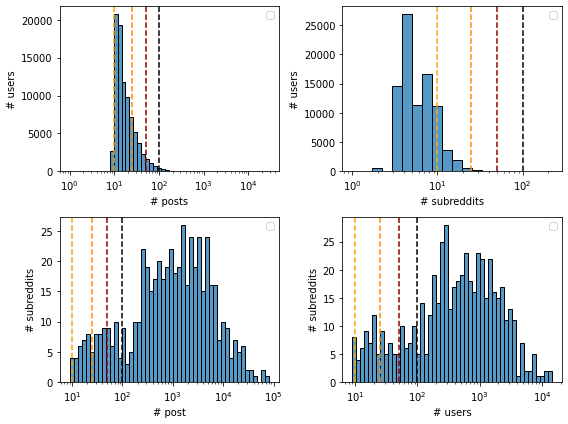

In [110]:
plot_aggregates(df, bins=[50, 20, 50, 50], vlines=[10, 25, 50, 100], figsize=(8,6), nrows=2, ncols=2)

## Subset subreddits
Here, we create a dataset including only the top 500 subreddits.

In [112]:
srdict = {}
for sr in df.subreddit.unique():
    srdict[sr] = df[df['subreddit'] == sr]['subreddit_posts_count'].iloc[0]
srdict = [(k,v) for k, v in sorted(srdict.items(), reverse=True, key=lambda item: item[1])]
srdict = srdict[:500]
srdict = [s[0] for s in srdict]

In [113]:
df = df[df['subreddit'].isin(srdict)]
df = update_aggregates(df)

In [114]:
sizedict = log_size(df, sizedict, '500sr_subset', sizelog)
print(f'There are {df.author.nunique()} users, {df.shape[0]} posts, {df.subreddit.nunique()} subreddits')

There are 87594 users, 1865767 posts, 500 subreddits


## Further preprocessing

Drop duplicates

In [115]:
df = df.drop_duplicates('selftext')
df = update_aggregates(df)

In [116]:
sizedict = log_size(df, sizedict, '5000sr_drop_duplicates', sizelog)
print(f'There are {df.author.nunique()} users, {df.shape[0]} posts, {df.subreddit.nunique()} subreddits')

There are 87594 users, 1830950 posts, 500 subreddits


Recount user posts and filter

In [117]:
df = df[(df['user_posts_count'] >= min_posts_per_user) & (df['user_nr_unique_subreddits'] >= min_unique_subreddits_per_user)]
df = update_aggregates(df)
print(f'Number of posts: {df.shape[0]}')

Number of posts: 1792618


Check if all subreddits satisfy the criteria

In [118]:
all(df['subreddit_posts_count'] >= min_posts_per_subreddit) and all(df['subreddit_nr_unique_users'] >= min_unique_users_per_subreddit)

True

Recompute size and store

In [119]:
sizedict = log_size(df, sizedict, '500sr_user_filter', sizelog)
print(f'There are {df.author.nunique()} users, {df.shape[0]} posts, {df.subreddit.nunique()} subreddits')

There are 83660 users, 1792618 posts, 500 subreddits


In [120]:
df.to_csv('processed/pushshift/dataset_500sr.txt', sep='\t', index=False)
#df = pd.read_csv('processed/pushshift/dataset_500sr.txt', sep='\t')

## Encode dataset
Set up tokenizer and encode all posts. <br>
Posts with > 512 tokens are truncated, shorter posts are padded to 512.

In [4]:
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

Downloading: 100%|██████████| 232k/232k [00:00<00:00, 353kB/s]


In [ ]:
df['selftext'] = df['selftext'].astype('str')

In [127]:
idxs = list(np.arange(0, df.shape[0], 100000)) + [df.shape[0]]
start = timeit.default_timer() 
timestamp = start

for i in range(len(idxs) - 1):
    print(f'Timestamp previous step {timestamp - start}')
    print(f'Encoding posts {idxs[i]} to {idxs[i+1]} out of {df.shape[0]}')
    clear_output(wait=True)
    tokenized = df['selftext'][idxs[i]:idxs[i+1]].apply(lambda x: tokenizer.encode_plus(' '.join(x.split()[:400]), 
                                                                                        truncation=True, 
                                                                                        padding='max_length'))
    if i == 0:
        tokdf = pd.DataFrame(tokenized)
    else:
        tokdf = pd.concat([tokdf, pd.DataFrame(tokenized)], ignore_index=True)
    timestamp = timeit.default_timer()

Timestamp previous step 2694.788070516999
Encoding posts 1700000 to 1792618 out of 1792618


Splice output dictionary in two columns and merge.

In [128]:
df['input_ids'] = tokdf['selftext'].apply(lambda x: x['input_ids'])
df['attention_mask'] = tokdf['selftext'].apply(lambda x: x['attention_mask'])

In [129]:
sizedict = log_size(df, sizedict, 'tokenize', sizelog)
print(f'There are {df.author.nunique()} users, {df.shape[0]} posts, {df.subreddit.nunique()} subreddits')

There are 83660 users, 1792618 posts, 500 subreddits


In [130]:
df.to_csv('processed/pushshift/dataset_500sr_encoded.txt', sep='\t', index=False)

## Plot final dataset

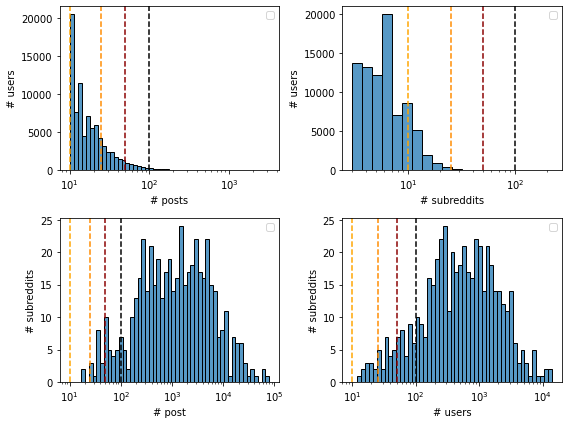

In [131]:
plot_aggregates(df, bins=[50, 20, 50, 50], vlines=[10, 25, 50, 100], figsize=(8,6), nrows=2, ncols=2)

In [132]:
print(f'There are {df.author.nunique()} users, {df.shape[0]} posts, {df.subreddit.nunique()} subreddits')

There are 83660 users, 1792618 posts, 500 subreddits


In [133]:
print(f'Min - avg - max posts per user: {df.user_posts_count.min()}, {df.user_posts_count.mean()}, {df.user_posts_count.max()}')
print(f'Min - avg - max subreddits per user: {df.user_nr_unique_subreddits.min()}, {df.user_nr_unique_subreddits.mean()}, {df.user_nr_unique_subreddits.max()}')
print(f'Min - avg - max posts per subreddit: {df.subreddit_posts_count.min()}, {df.subreddit_posts_count.mean()}, {df.subreddit_posts_count.max()}')
print(f'Min - avg - max users per subreddit: {df.subreddit_nr_unique_users.min()}, {df.subreddit_nr_unique_users.mean()}, {df.subreddit_nr_unique_users.max()}')

Min - avg - max posts per user: 10, 52.6554592222102, 3180
Min - avg - max subreddits per user: 3, 8.230257645521801, 219
Min - avg - max posts per subreddit: 17, 18894.090659582802, 78690
Min - avg - max users per subreddit: 12, 4082.1149988452644, 13808


Plot dataset size curve

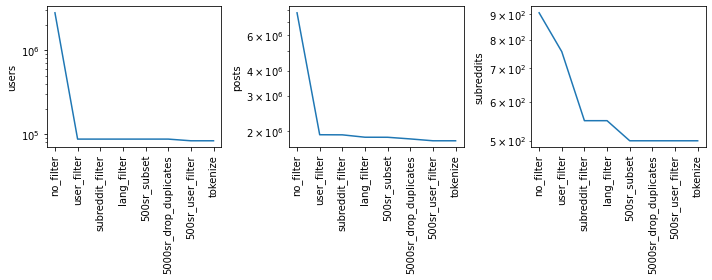

In [134]:
fig, ax = plt.subplots(ncols=3, figsize=(10,4), sharex=True)
for idx, metric in enumerate(['users', 'posts', 'subreddits']):
    sns.lineplot(x=sizedict['names'], y=sizedict[metric], ax=ax[idx])
    ax[idx].set_ylabel(metric)
    ax[idx].set_yscale('log')
    ax[idx].set_xticklabels(sizedict['names'], rotation=90)
plt.tight_layout()
plt.show()

## Check subreddit distribution

In [4]:
df = pd.read_csv('processed/pushshift/dataset_500sr_encoded.txt', 
                 converters={'input_ids': lambda x: json.loads(x),
                             'attention_mask': lambda x: json.loads(x)}, sep='\t')

In [5]:
df = df.sort_values('created_utc').reset_index(drop=True)

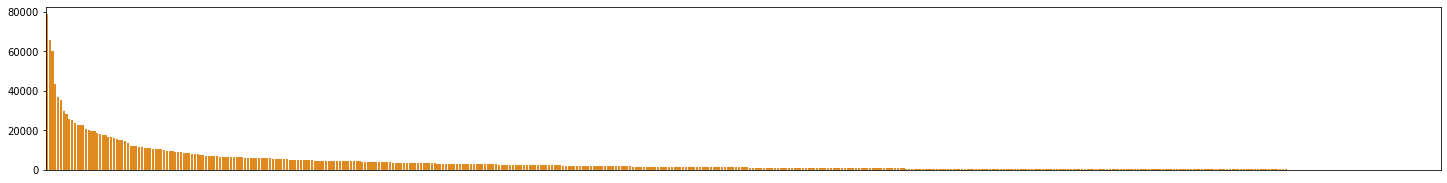

In [6]:
fig, ax = plt.subplots(figsize=(25,3))
sns.barplot(x=df['subreddit'].value_counts().index, y=df['subreddit'].value_counts().values, color='darkorange')
plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
plt.show()

## Create negative examples for triplet loss + classification network

In [15]:
ds_cols = ['author', 'input_ids', 'attention_mask', 'selftext']

Create masks for posts used as positive or negative examples

In [8]:
n_ex = 2
def pick_masks(x):
    return x.loc[np.random.choice(x.index, 2, 
                                  replace=False),:]

In [9]:
ndf = df.groupby('author', as_index=False).apply(pick_masks)
ndf_idx = ndf.reset_index()['level_1'].values
ndf = ndf.reset_index(drop=True)

In [13]:
# Ndf is the dataframe of posts used as negative or positive examples

167320

Drop positive and negative examples from dataframe

In [14]:
df = df.drop(ndf_idx, axis=0)

Stack posts

In [17]:
def stack_fn(x):
    return [np.vstack(np.array(x))]

In [18]:
df_stacked = df[ds_cols].groupby('author').aggregate(stack_fn).reset_index()

In [20]:
stext = df_stacked['selftext']
df_stacked = df_stacked.drop('selftext', axis=1)

Find positive and negative examples

In [21]:
# Initialize variables
valid_idx = ndf.index # Set of indices to choose from (updated over iterations)
df_stacked['pos_idx_1'] = np.nan
df_stacked['neg_idx_1'] = np.nan
df_stacked['pos_idx_2'] = np.nan
df_stacked['neg_idx_2'] = np.nan

# Loop over users
for a in df_stacked.author.unique()[:2]:

    # Take positive examples from author
    pos_idxs = ndf[ndf['author'] == a].index.tolist() # Take the two pos idx
    neg_idxs = list(set(valid_idx) - set(pos_idxs)) # Take possible remaining neg idx
    idxs = np.random.choice(neg_idxs, 2, replace=False) # Sample two neg idx
    
    # Add pos and neg idx in main dataframe
    df_stacked['neg_idx_1'][df_stacked['author'] == a] = int(idxs[0])
    df_stacked['pos_idx_1'][df_stacked['author'] == a] = int(pos_idxs[0])
    df_stacked['neg_idx_2'][df_stacked['author'] == a] = int(idxs[1])
    df_stacked['pos_idx_2'][df_stacked['author'] == a] = int(pos_idxs[1])

    # Update possible indices and log status
    valid_idx = list(set(valid_idx) - set(idxs))
    if len(valid_idx) % 5000 == 0:
        clear_output(wait=True)
        print(f'Remaining examples: {len(valid_idx)} out of {len(ndf.index)}')

## Store triplet network dataset

In [28]:
triplet_nn1_types = (tf.int32, tf.int32)

Create generator

In [70]:
def triplet_nn1_gen(ds):
    for index, row in ds.iterrows():
        p1_idx = int(row['pos_idx_1'])
        p2_idx = int(row['pos_idx_2'])
        n1_idx = int(row['neg_idx_1'])
        n2_idx = int(row['neg_idx_2'])
        for idx in [ (p1_idx, n1_idx), (p2_idx, n2_idx) ]:
            iids = np.vstack([row['input_ids'][0], # indexing issue?
                              np.array(ndf.iloc[idx[0],:]['input_ids']), 
                              np.array(ndf.iloc[idx[1],:]['input_ids']) ])
            attmask = np.vstack([row['attention_mask'][0], 
                                 np.array(ndf.iloc[idx[0],:]['attention_mask']), 
                                 np.array(ndf.iloc[idx[1],:]['attention_mask']) ])
            yield (iids, attmask)

Save as tfrecord

In [ ]:
ds_triplet = tf.data.Dataset.from_generator(generator=lambda: triplet_nn1_gen(df_stacked), 
                                            output_types=triplet_nn1_types)
save_tfrecord_triplet_nn1(ds_triplet, shard=True, n_shards=1000, 
                          path='datasets/example/fake/', compression='GZIP')

In [ ]:
# Notes:
# There are two examples per user (possibly reduce to one only?)
# Need to refactor the code
# Need to store information on the text
# Possibly implement smarter selection 
    # By user: same-subreddit - different-subreddit
    # By subreddit: same-user - different-user
# RERUN THE WHOLE THING